# Bootstraping

Environment: R 3.6.1 and Jupyter notebook

Libraries used:
* dplyr
* reshape2
* ggplot2

## Introduction

In this notebook, Bootstrap need to be implemented on KNN regressor , which is defined in the `knn_regressor.ipynb`. 

Bootstraping is a statistical method to sample the data from existed dataset, which can measure uncertainty in the prediction of a model. Also, the it can also help to improve the performance of the model by sampling the dataset with larger size.

In this notebook, the model with different K and the model with different sample-size bootstraping will to be visualized.

## Import libraries

In [1]:
options(warn=-1)
library(dplyr)
library(reshape2)
library(ggplot2)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
read_data <- function(fname, sc) {
  data <- read.csv(file = fname, head = TRUE, sep = ",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  x = data[1:nr, 1:(nc - 1)]
  y = data[1:nr, nc]
  if (isTRUE(sc)) {
    x = scale(x)
    y = scale(y)
  }
  return(list("x" = x, "y" = y))
}

KNNRegressor <- setRefClass("KNNRegressor",
                            fields = list(k = "numeric", x_train = "data.frame", y_train = "data.frame"),
                            methods = list(
                                
                              initialize = function(k) {
                                .self$k <- k
                              },

                              fit = function(x_train, y_train) {
                                .self$x_train <- x_train
                                .self$y_train <- y_train
                                .self
                              },

                              predict = function(x_test) {
                                # define a inner function `majority`  
                                majority <- function(x) mean(x)
                                # define a inner function for applying each row
                                predict_for_row <- function(x_test_row) {
                                  # calculate the distance for each test data
                                  distance <- .self$x_train %>% 
                                    apply(1, function(x_train_row) {
                                    # Manhattan distance function
                                    x_train_row["dist"] <- sum(abs(x_train_row - x_test_row))
                                    x_train_row
                                    }) %>% 
                                    t %>% 
                                    as.data.frame %>% .["dist"]
                                    
                                  # find the K nearest neighbours' labels
                                  nearest_indexes <- order(distance$dist)[1:k]
                                  train_labels <- .self$y_train[nearest_indexes,]
                                  # predict the test labels with the mean of nearest neighbours
                                  y_pred_row <- majority(train_labels)
                                  y_pred_row
                                }
                                
                                y_pred <- apply(x_test, 1, predict_for_row)
                                y_pred
                              }
                            )
)

knn <- function(train.data, train.label, test.data, K) {
  knn_regressor <- KNNRegressor(K)$fit(as.data.frame(train.data), as.data.frame(train.label))
  knn_regressor$predict(as.data.frame(test.data))
}

error_func <- function(test.pred, test.label) {
  mean((test.pred - test.label) ^ 2)
}

## Read data

In [3]:
train_data <- read.csv("train2.csv")
test_data <- read_data("test2.csv", FALSE)
x_test <- test_data$x
y_test <- test_data$y
head(train_data)

x1,x2,x3,x4,y
1991.496,1628.75,1678.1,1772.8,2443.6
1991.504,1606.51,1678.6,1718.0,2448.2
1991.512,1618.16,1686.6,1723.1,2484.7
1991.519,1630.75,1682.9,1734.5,2487.9
1991.527,1635.47,1697.5,1754.0,2510.5
1991.535,1647.84,1723.8,1759.8,2532.5


## Implement Bootstrap

A class `Bootstrap` is defined in this section for generic purpose. In the implementation, the data with multiple variables is considered.

The class `Bootstrap` contains

* fields:
  * `original_dataset`: The dataset input for bootstrapping.
  * `original_size`: The size of original dataset.
  * `sample_size`: THe size of the boot sample.
* methods:
  * `sample`: Bootstrapping with `times` specified
  * `sample_once`: Sample once with bootstrapping.

In [4]:
Bootstrap <- setRefClass("Bootstrap",
                         fields = list(
                           original_dataset = "data.frame",
                           original_size = "numeric",
                           sample_size = "numeric"),
                         methods = list(
                           initialize = function(original_dataset, sample_size) {
                             .self$original_dataset <- original_dataset
                             # get the original size by getting the row of original dataset
                             .self$original_size <- nrow(original_dataset)
                             .self$sample_size <- sample_size
                           },

                           sample = function(times) {
                             # for each time, generate a bootstrapping indexes and concat by rows
                             indexes <- Reduce(rbind, lapply(1:times, function(t) base::sample(x = .self$original_size,
                                                       size = .self$sample_size, replace = TRUE)))
                             # from indexes get data from original dataset
                             result <- apply(indexes, 1, function(indexes) .self$original_dataset[indexes,])
                             result
                           },

                           sample_once = function() {
                             .self$sample(1)[[1]]
                           }
                         )
)

In [5]:
boot <- function(original_dataset, sample_size, times) {
    Bootstrap(original_dataset, sample_size)$sample(times)
}

## Visualization

#### Part 1
Firstly visualize something. Let's plot with `K = 1 to 15`, `times = 50`, `size = 20`,

In [ ]:
# time consumption: about 5 minutes
# get the boot data with specified size and times
boot_data <- boot(train_data, sample_size = 20, times = 50)

# define a function for calculate errors from data and K
cal_error <- function(data, k) {
  pred <- knn(train.data = data[,-5], train.label = data[,5], test.data = x_test, K = k)
  error_func(pred, y_test)  
}

# calculate the errors when K is in 1:15
errors <- Reduce(rbind, lapply(1:15, function(i) {
  sapply(boot_data, cal_error, k=i)
}))

In [7]:
# reformat the names of columns and rows
rownames(errors) <- 1:15
colnames(errors) <- NULL
errors

1,18456.35,25965.87,23033.05,56884.68,74780.6,30821.32,62404.46,26514.73,28439.57,29840.01,...,30887.89,33814.26,31111.81,83224.30,26611.90,34896.29,31004.41,102533.6,160288.4,43463.49
2,23483.80,31150.60,15912.78,121112.67,127081.6,43224.70,48949.08,20123.16,28710.02,40125.07,...,29217.85,43139.31,35173.09,80275.06,27479.23,52518.04,24635.34,119611.1,196014.9,49013.66
3,32688.07,39941.70,22519.41,159429.03,227105.6,64338.80,38626.44,22086.92,41053.32,55258.50,...,48946.90,54042.51,49126.88,75083.23,25149.59,86098.36,21940.64,151448.3,236477.8,50215.05
4,44657.52,56302.17,32909.36,213263.07,322843.1,90061.52,41504.05,34678.12,60076.87,81802.22,...,80250.65,76398.86,86415.50,131568.95,35839.05,148290.91,39186.78,175198.8,294513.7,56210.67
5,56739.36,74674.87,39540.59,272896.98,397721.8,140694.21,58342.31,50815.38,80581.71,125767.37,...,124445.39,92883.43,147526.60,195665.67,59610.76,229218.10,66504.27,199714.8,316695.8,57649.93
6,74052.61,104887.75,59780.50,309904.03,434662.4,195257.13,59050.74,67759.02,110570.35,173442.16,...,182900.45,131089.19,214543.52,271312.57,85150.15,301408.81,109164.71,248778.7,355667.2,81791.48
7,95996.93,135259.72,86317.25,343564.96,486301.3,245905.91,87018.67,89192.22,142420.27,209074.43,...,241330.78,175454.03,290061.03,328768.02,121447.95,368804.63,149807.28,292516.3,409474.7,123522.81
8,127033.49,165717.33,117521.93,409135.64,528514.9,304950.51,124582.37,119051.36,169327.44,241131.75,...,290531.26,224849.62,348448.33,382075.52,153892.93,417090.69,187291.88,337135.8,465896.3,162164.70
9,169439.31,200517.25,156460.31,461728.85,558148.3,363544.47,165068.76,150234.92,219892.01,298953.55,...,336086.09,281790.83,410473.78,439340.07,196788.42,482159.09,236508.73,399792.0,489337.1,198864.48
10,225538.85,250974.76,197820.18,487454.71,589162.8,428804.89,210450.50,182976.62,258712.25,333184.37,...,395289.17,323022.74,472815.97,494229.94,240716.36,528685.04,283121.46,436032.3,519359.9,242115.86
11,272400.96,293015.22,237406.09,512075.40,637503.0,488555.28,260702.27,233035.18,313775.25,377073.24,...,432918.61,378388.75,527064.63,542888.68,286085.82,585180.96,332764.27,484618.6,550707.9,283639.92


In [8]:
# melt the errors for plot
errors_melt <- errors %>% t %>% melt

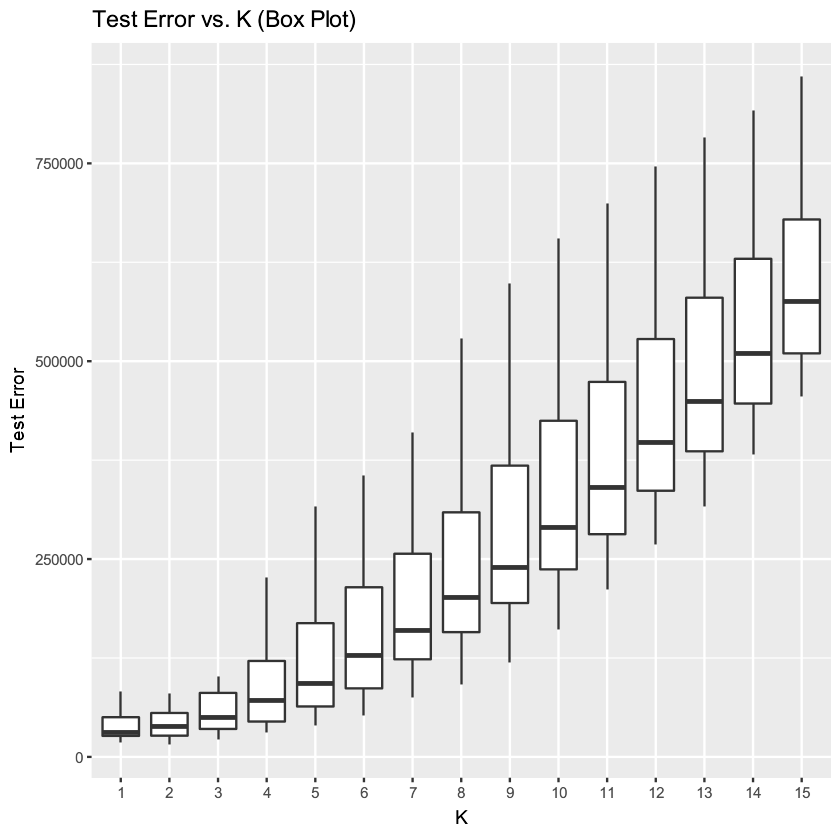

In [9]:
# plot
ggplot() + geom_boxplot(data = errors_melt, mapping = aes(x=factor(Var2), y=value), outlier.shape = NA) + 
  labs(x = "K", y = "Test Error") + ggtitle('Test Error vs. K (Box Plot)')

options(warn=-1)

##### Explain:
From the plot, when the `sample_size` is fixed as 20, the `K` increases and the test error also increases. Also, the uncertainty can be considered as the range of the distribution, so when `K` increases, the uncertainty also increases.

#### Part 2
Another plot is visualizing errors when the sizes changes and K is fixed as `K = 5`.

Apply the similar method to visualize it.

In [10]:
# time consumption: about 5 minutes
# define the sizes
sizes <- seq(5, 75, 5)

# calculate the errors from different sizes
errors_with_sizes <- Reduce(rbind, lapply(sizes, function(size) {
  # for each size, calculate the errors
  boot_data <- boot(train_data, sample_size = size, times = 50)  
  sapply(boot_data, function(data) cal_error(data, k=5))
}))

# reformat the names of errors matrix
rownames(errors_with_sizes) <- sizes
colnames(errors_with_sizes) <- NULL    
errors_with_sizes

5,1100587.00,1075042.58,1244658.08,976242.05,1155084.12,956073.53,1048587.67,1230756.15,1212164.22,964744.70,...,978667.01,981404.50,965201.77,978709.48,1777944.27,1728357.10,1011285.01,969519.11,984993.15,989483.05
10,398715.34,200738.59,233917.95,308248.63,221027.75,325371.90,375737.42,316577.51,307048.95,1022111.86,...,179754.63,541481.30,395132.91,187656.75,227861.36,373622.99,235406.71,558555.02,484890.23,401998.91
15,183716.67,299609.05,342526.26,107596.00,463519.91,174766.76,191413.94,259286.32,315564.42,99608.13,...,329011.53,498720.54,248899.81,117432.87,254290.88,234386.66,597156.06,234205.51,115217.18,224769.35
20,286537.84,124599.12,95300.30,150780.59,169613.14,68954.28,90003.83,50433.30,105877.05,267174.05,...,49110.65,198329.61,90641.88,155772.38,132409.37,40249.38,206989.07,142175.46,154750.28,156626.27
25,38284.52,27271.93,38995.94,119739.72,182619.77,297429.62,46172.81,78736.19,23282.39,33290.29,...,102013.54,145602.44,68952.14,31746.12,58158.88,141665.74,96979.20,30337.72,44633.37,70152.58
30,36019.95,54687.14,27756.27,32465.82,37126.17,74351.84,204161.56,109940.78,96868.00,64309.34,...,64250.10,29532.40,82657.75,22084.67,41235.14,34344.64,49742.93,121587.56,36015.07,32656.20
35,25119.90,44964.21,39563.23,29028.66,33389.18,31804.47,21834.70,26571.94,36937.20,68658.90,...,78893.19,75172.03,49074.16,98690.63,37522.23,31888.21,15864.07,61477.09,24425.25,38195.11
40,29106.17,61362.32,24809.12,24166.12,55571.82,127148.73,33448.09,20650.41,22419.42,14652.73,...,60252.95,16680.45,25644.85,56962.30,27857.62,21631.06,24003.29,21883.86,18922.96,21311.59
45,18984.60,42679.32,13701.80,18231.74,17745.05,22636.31,21953.95,16300.00,22340.03,18975.37,...,15271.12,18760.53,26087.21,105655.79,165794.05,31168.32,19963.52,36935.18,18545.03,95249.19
50,70445.52,20930.76,17176.27,37085.12,25496.17,16677.42,14029.94,30659.85,17423.63,17569.65,...,25689.45,12412.78,23443.20,48769.94,22195.39,16784.37,20397.62,14912.11,24659.97,22241.01
55,18247.04,28005.26,48875.55,11165.60,30772.55,17216.38,20873.68,29671.06,36816.17,16380.55,...,43264.43,16570.60,44115.22,19543.12,14246.74,15539.24,16081.20,21067.79,29422.59,21836.66


In [11]:
# melt for visualization
errors_with_sizes_melt <- errors_with_sizes %>% as.matrix %>% melt

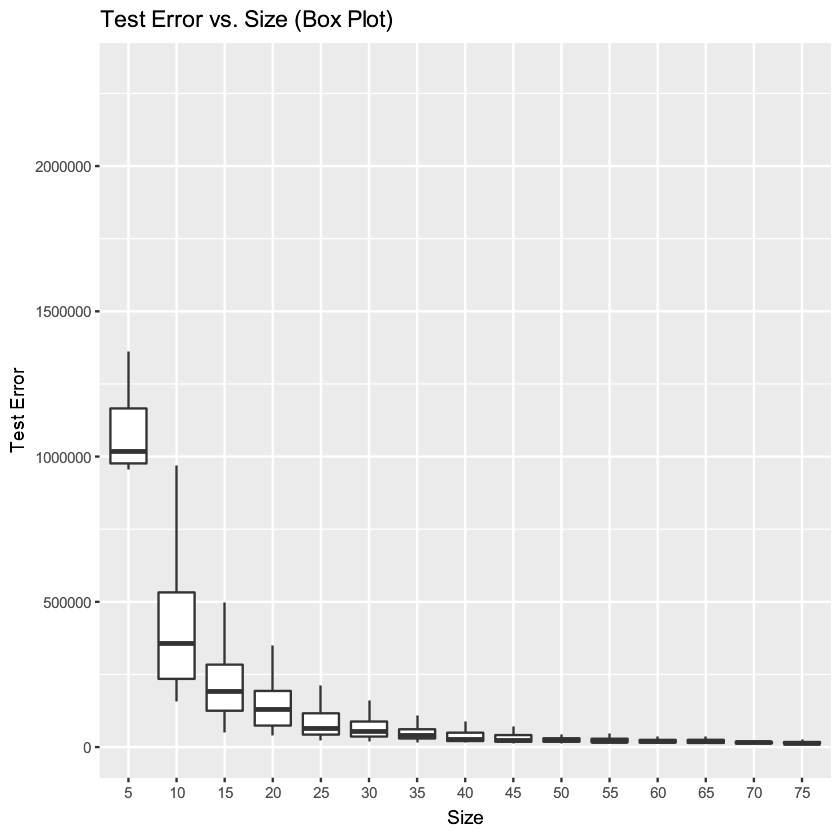

In [13]:
# plot
ggplot() + geom_boxplot(data = errors_with_sizes_melt, mapping = aes(x=factor(Var1), y=value), outlier.shape = NA) +
  labs(x = "Size", y = "Test Error") + ggtitle('Test Error vs. Size (Box Plot)')

options(warn=-1)

##### Explain:
From the plot, when the `K` is fixed as 5, the `sample_size` increases and the test error decreases. Also, the uncertainty decreases when `sample_size` is increasing.